# Natural Language Processing

## Real or not? NLP with disaster tweets

### Introduction (from the original Kaggle competition)

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies). But it’s not always clear whether a person’s words are actually announcing a disaster.

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

This dataset was created by the company figure-eight and originally shared on their ‘Data For Everyone’ website.

Tweet source: https://twitter.com/AnyOtherAnnaK/status/629195955506708480

### Settings

Import required libraries

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re 
import string
from datetime import datetime

from string import punctuation
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
sno= nltk.stem.SnowballStemmer('english')
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from nltk.classify import MaxentClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report

import os
import re

from spellchecker import SpellChecker

### Data Import

The `path` variable may be adjusted appropriately. In this case, the data files are locally stored alongside the notebook:

In [ ]:
path = "./"

In [ ]:
training = pd.read_csv(path + "train.csv")
test = pd.read_csv(path + "test.csv")

Basic inspection of the dataframes (shape, column names, first rows):

In [ ]:
training.shape

(7613, 5)

In [ ]:
training.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [ ]:
test.shape

(3263, 4)

In [ ]:
test.columns

Index(['id', 'keyword', 'location', 'text'], dtype='object')

In [ ]:
training.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Data Analysis

Inspect the proportion of **null** values in both the training and test sets:

In [ ]:
training.isnull().sum()/len(training)*100

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64

In [ ]:
test.isnull().sum()/len(test)*100

id           0.000000
keyword      0.796813
location    33.864542
text         0.000000
dtype: float64

Both dataframes have null values in the same columns (`keyword` and `location`) and in roughly the same proportion. `location` has about one third of null values, which is significant.

For the time being, these null values are "imputed" with the strings `no_kw` and `no_loc`, respectively.

In [ ]:
training["keyword"].fillna("no_kw", inplace=True)
test["keyword"].fillna("no_kw", inplace=True)

In [ ]:
training["location"].fillna("no_loc", inplace=True)
test["location"].fillna("no_loc", inplace=True)

Inspect the distribution of **unique** values:

In [ ]:
training[training["keyword"] != "no_kw"]["keyword"].value_counts()

fatalities               45
armageddon               42
deluge                   42
sinking                  41
damage                   41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
test[test["keyword"] != "no_kw"]["keyword"].value_counts()

deluged               23
demolished            22
rubble                22
obliteration          21
first%20responders    21
                      ..
threat                 5
fatalities             5
forest%20fire          5
inundation             4
epicentre              1
Name: keyword, Length: 221, dtype: int64

In [ ]:
set(test[test["keyword"] != "no_kw"]["keyword"].value_counts().index) == \
set(training[training["keyword"] != "no_kw"]["keyword"].value_counts().index)

True

The distribution of unique (non-null) `keyword` values is identical in the training and test sets (the same 221 unique values appear in both dataframes).

In [ ]:
training[training["location"] != "no_loc"]["location"].value_counts()

USA                     104
New York                 71
United States            50
London                   45
Canada                   29
                       ... 
Books Published, USA      1
fujo garbage heaven       1
New Mexico, USA           1
Rockland County, NY       1
in my head                1
Name: location, Length: 3341, dtype: int64

In [ ]:
test[test["location"] != "no_loc"]["location"].value_counts()

New York                     38
USA                          37
Worldwide                    16
United States                15
London                       13
                             ..
St.Louis                      1
California, United States     1
424 N. FAIRFAX AVE. 90036     1
17 year old anti-theist.      1
earth                         1
Name: location, Length: 1602, dtype: int64

There is an excessive scatter of unique values in the `location` column, partly stemming from this feature being messy in its source, as can be seen in some of the examples above (*The Memesphere*, *sarah's dreads*, ...).

Consequently, this column is not to be used as a feature.

In [ ]:
training["text"].nunique()

7503

In [ ]:
print(f"There are {len(training)-training['text'].nunique()} tweet repetitions in the training set")

There are 110 tweet repetitions in the training set


In [ ]:
test["text"].nunique()

3243

In [ ]:
print(f"There are {len(test)-test['text'].nunique()} tweet repetitions in the test set")

There are 20 tweet repetitions in the test set


There are repeated tweets in both dataframes. Let us inspect these subsets:

In [ ]:
training["text"].value_counts()[training["text"].value_counts().values > 1]

11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very tro

There are 69 repeated tweets in the training set, ranging from the *11-Year-Old Boy* tweet appearing 10 times to other tweets just being repeated once. Check if the `target` is consistent amongst repetitions:

In [ ]:
tmp = training["text"].value_counts()[training["text"].value_counts().values > 1]
tmp = list(tmp.index)

In [ ]:
training[training["text"].isin(tmp)]

,id,keyword,location,text,target
40,59,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,68,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,156,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,165,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,171,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...,...,...,...
7600,10855,no_kw,no_loc,Evacuation order lifted for town of Roosevelt:...,1
7607,10867,no_kw,no_loc,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,10870,no_kw,no_loc,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,no_kw,no_loc,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


Sanity check that the number of rows is correct:

In [ ]:
training["text"].value_counts()[training["text"].value_counts().values > 1].sum()

179

Filter the training set to show only the repeated tweets, their count and the target sum:

In [ ]:
tmp = training[training["text"].isin(tmp)]

In [ ]:
tmp.groupby("text")[["target"]].agg(['count','sum'])

target    
                                                    count sum
text                                                         
#Allah describes piling up #wealth thinking it ...      3   1
#Bestnaijamade: 16yr old PKK suicide bomber who...      6   6
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3...      2   2
#Myanmar  Displaced #Rohingya at #Sittwe point ...      2   2
#Newswatch: 2 vehicles collided at Lock and Lan...      2   2
...                                                   ...  ..
incident with injury:I-495  inner loop Exit 31 ...      2   2
like for the music video I want some real actio...      2   1
that exploded &amp; brought about the\nbeginnin...      2   0
that horrible sinking feeling when youÛªve bee...      4   2
wowo--=== 12000 Nigerian refugees repatriated f...      2   1

[69 rows x 2 columns]

If the `target` were consistent amongst repeated tweets, then the `sum` column above should either be zero or equal to the `count`. 

In [ ]:
tmp = tmp.groupby("text")[["target"]].agg(['count','sum'])

Filter only the tweets with inconsistencies in `target`:

In [ ]:
c1 = tmp[('target', 'sum')] != 0
c2 = tmp[('target', 'sum')] != tmp[('target', 'count')]

tmp[c1 & c2]

target    
                                                    count sum
text                                                         
#Allah describes piling up #wealth thinking it ...      3   1
#foodscare #offers2go #NestleIndia slips into l...      3   2
.POTUS #StrategicPatience is a strategy for #Ge...      4   3
CLEARED:incident with injury:I-495  inner loop ...      3   2
Caution: breathing may be hazardous to your hea...      2   1
He came to a land which was engulfed in tribal ...      6   2
Hellfire is surrounded by desires so be careful...      3   1
Hellfire! We donÛªt even want to think about i...      2   1
I Pledge Allegiance To The P.O.P.E. And The Bur...      2   1
In #islam saving a person is equal in reward to...      2   1
Mmmmmm I'm burning.... I'm burning buildings I'...      2   1
RT NotExplained: The only known image of infamo...      2   1
The Prophet (peace be upon him) said 'Save your...      6   2
To fight bioterrorism sir.                              4   2
Who is bringing the tornadoes and floods. Who i...      3   1
like for the music video I want some real actio...      2   1
that horrible sinking feeling when youÛªve bee...      4   2
wowo--=== 12000 Nigerian refugees repatriated f...      2   1

In [ ]:
print(f"{len(tmp[c1 & c2])} repeated tweets in the training set have contradicting target values")

18 repeated tweets in the training set have contradicting target values


One programmatic way to solve these contradicting `target` values would be to assign to each tweet the majority vote and remove the duplicates. In this case, since the amount of conflicting cases is so small, they are manually reviewed (on an individual basis).

Before the manual review, store both dataframes of consistent and inconsistent repetitions:

In [ ]:
rep_tweet_consist = tmp[~(c1 & c2)]

In [ ]:
rep_tweet_inconsist = tmp[c1 & c2]

Sanity check:

In [ ]:
len(rep_tweet_consist) + len(rep_tweet_inconsist)

69

Check the `keyword` column amongst repeated tweets:

In [ ]:
tmp = training["text"].value_counts()[training["text"].value_counts().values > 1]
tmp = training[training["text"].isin(list(tmp.index))]
tmp.groupby("text")[["keyword"]].agg(['nunique'])

,keyword
,nunique
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,1
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,1
#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,1
#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,1
...,...
incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,1
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,2


In [ ]:
tmp.groupby("text")[["keyword"]].agg(['nunique']).max()

keyword  nunique    2
dtype: int64

At most there are 2 keywords for a repeated tweet.

In [ ]:
tmp.groupby("text")[["keyword"]].agg(['nunique']).sum()

keyword  nunique    92
dtype: int64

In [ ]:
tmp.groupby("text")[["keyword"]].agg(['unique'])

,keyword
,unique
text,
#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect,[hellfire]
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,[suicide%20bomb]
#KCA #VoteJKT48ID 12News: UPDATE: A family of 3 has been displaced after fired damaged housed near 90th and Osborn. Fire extinguished no iÛ_,[displaced]
#Myanmar Displaced #Rohingya at #Sittwe point of no return http://t.co/cgf61fPmR0 #Prison like conditions #genocide IHHen MSF Refugees,[displaced]
#Newswatch: 2 vehicles collided at Lock and Lansdowne Sts in #Ptbo. Emerg crews on their way,[collided]
...,...
incident with injury:I-495 inner loop Exit 31 - MD 97/Georgia Ave Silver Spring,[injury]
like for the music video I want some real action shit like burning buildings and police chases not some weak ben winston shit,"[buildings%20burning, burning%20buildings]"


23 (i.e. 92-69) of the repeated tweets are associated with two different keywords. Although this could be further looked into, it is disregarded for the time being (in some cases, as in the example in row 66 above, the `keyword` is not identical amongst repetitions but conveys the same meaning). 

In order to proceed with the manual review of the repeated tweets with inconsistent `target` values, inspect a sample of tweets consistently labelled with `target` value 1, to get an idea of the contents expected in a *disaster related* tweet:

In [ ]:
rep_tweet_consist[rep_tweet_consist[('target','count')] == \
                  rep_tweet_consist[('target','sum')]].sample(10, random_state=2)

target    
                                                    count sum
text                                                         
11-Year-Old Boy Charged With Manslaughter of To...     10  10
#Bestnaijamade: 16yr old PKK suicide bomber who...      6   6
USGS reports a M1.94 #earthquake 5km S of Volca...      2   2
@fewmoretweets all lives matter. Just not a fan...      2   2
@themagickidraps not upset with a rally upset w...      2   2
UD: Rescue (Structural Collapse) - Scott Road @...      2   2
Evacuation order lifted for town of Roosevelt: ...      2   2
Swansea Û÷plot hijack transfer move for Southa...      2   2
Japan on Thursday marks the 70th anniversary of...      2   2
http://t.co/c1H7JECFrV @RoyalCarribean do your ...      2   2

In [ ]:
rep_tweet_inconsist

target    
                                                    count sum
text                                                         
#Allah describes piling up #wealth thinking it ...      3   1
#foodscare #offers2go #NestleIndia slips into l...      3   2
.POTUS #StrategicPatience is a strategy for #Ge...      4   3
CLEARED:incident with injury:I-495  inner loop ...      3   2
Caution: breathing may be hazardous to your hea...      2   1
He came to a land which was engulfed in tribal ...      6   2
Hellfire is surrounded by desires so be careful...      3   1
Hellfire! We donÛªt even want to think about i...      2   1
I Pledge Allegiance To The P.O.P.E. And The Bur...      2   1
In #islam saving a person is equal in reward to...      2   1
Mmmmmm I'm burning.... I'm burning buildings I'...      2   1
RT NotExplained: The only known image of infamo...      2   1
The Prophet (peace be upon him) said 'Save your...      6   2
To fight bioterrorism sir.                              4   2
Who is bringing the tornadoes and floods. Who i...      3   1
like for the music video I want some real actio...      2   1
that horrible sinking feeling when youÛªve bee...      4   2
wowo--=== 12000 Nigerian refugees repatriated f...      2   1

Manual `target` review upon individual revision of the tweets above:

In [ ]:
rep_tweet_inconsist["target","new"] = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
rep_tweet_inconsist

target        
                                                    count sum new
text                                                             
#Allah describes piling up #wealth thinking it ...      3   1   0
#foodscare #offers2go #NestleIndia slips into l...      3   2   1
.POTUS #StrategicPatience is a strategy for #Ge...      4   3   0
CLEARED:incident with injury:I-495  inner loop ...      3   2   1
Caution: breathing may be hazardous to your hea...      2   1   1
He came to a land which was engulfed in tribal ...      6   2   0
Hellfire is surrounded by desires so be careful...      3   1   0
Hellfire! We donÛªt even want to think about i...      2   1   0
I Pledge Allegiance To The P.O.P.E. And The Bur...      2   1   0
In #islam saving a person is equal in reward to...      2   1   0
Mmmmmm I'm burning.... I'm burning buildings I'...      2   1   0
RT NotExplained: The only known image of infamo...      2   1   0
The Prophet (peace be upon him) said 'Save your...      6   2   0
To fight bioterrorism sir.                              4   2   0
Who is bringing the tornadoes and floods. Who i...      3   1   0
like for the music video I want some real actio...      2   1   0
that horrible sinking feeling when youÛªve bee...      4   2   0
wowo--=== 12000 Nigerian refugees repatriated f...      2   1   0

Remove *all* duplicate tweets from the training dataframe:

In [ ]:
training.drop_duplicates(subset="text", inplace=True)

Substitute the `target` values in the tweets originally repeated with inconsistencies for the reviewed ones above via an auxiliary dictionary:

In [ ]:
tmp = dict(rep_tweet_inconsist["target","new"])

In [ ]:
training.loc[training["text"].isin(rep_tweet_inconsist.index),["target"]] = training[training["text"].isin(rep_tweet_inconsist.index)]["text"].map(lambda x:tmp[x])

Sanity check that these tweets have indeed been assigned the new `target` values:

In [ ]:
training.loc[training["text"].isin(rep_tweet_inconsist.index),["text","target"]]

,text,target
610,To fight bioterrorism sir.,0
1197,Mmmmmm I'm burning.... I'm burning buildings I...,0
1214,I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1221,like for the music video I want some real acti...,0
2830,.POTUS #StrategicPatience is a strategy for #G...,0
3240,He came to a land which was engulfed in tribal...,0
3985,Who is bringing the tornadoes and floods. Who ...,0
4221,#foodscare #offers2go #NestleIndia slips into ...,1
4232,Caution: breathing may be hazardous to your he...,1
4284,The Prophet (peace be upon him) said 'Save you...,0


Check the `keyword` column amongst repeated tweets in the test set:

In [ ]:
tmp = test["text"].value_counts()[test["text"].value_counts().values > 1]
tmp = test[test["text"].isin(list(tmp.index))]
tmp.groupby("text")[["keyword"]].agg(['nunique'])

,keyword
,nunique
text,
#AskConnor there's a zombie apocalypse. the item to your right is your weapon. you're either screwed or you're gonna live.,2
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1
.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes,2
.POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4,1
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...,1
320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/THyzOMVWU0 | @djicemoon | #Dubstep #TrapMusic #DnB #EDM #Dance #IcesÛ_ http://t.co/83jOO0xk29,1
70 yrs since the atomic bombing of Hiroshima... Terrible mass murder...,2
@PumpkinMari_Bot lemme just derail this real quivk to say. HELL DAMN F,1


Only 4 repeated tweets in the test set are associated to 2 different keywords. Let us inspect these cases:

In [ ]:
tmp.groupby("text")[["keyword"]].agg(['unique']).iloc[[0,2,6,11]]

,keyword
,unique
text,
#AskConnor there's a zombie apocalypse. the item to your right is your weapon. you're either screwed or you're gonna live.,"[apocalypse, weapon]"
.@denisleary Not sure how these folks rush into burning buildings but I'm grateful they do. #TrueHeroes,"[buildings%20burning, burning%20buildings]"
70 yrs since the atomic bombing of Hiroshima... Terrible mass murder...,"[bombing, mass%20murder]"
IRIN Asia | Red tape tangles Nepal reconstruction | Nepal | Disaster Risk Reduction | Natural Disasters http://t.co/q7LG6ncf7G,"[disaster, natural%20disaster]"


The `keyword` pairs are not inconsistent. It may be convenient to leave them as is and check at the end if the predictions for each of these 4 pairs leads to the same `target` value. 

New shape of the training set:

In [ ]:
training.shape

(7503, 5)

Lastly, inspect the class balance in the training set:

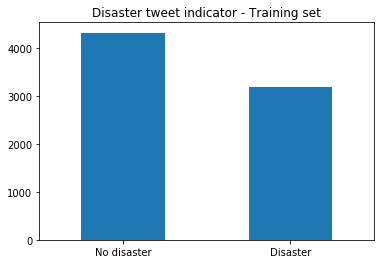

In [ ]:
training["target"].value_counts().plot(kind = 'bar')

plt.xticks(ticks=range(2), labels=("No disaster","Disaster"), rotation=0)
plt.title("Disaster tweet indicator - Training set")
plt.show()

In [ ]:
training["target"].value_counts()/len(training)*100

0    57.470345
1    42.529655
Name: target, dtype: float64

The distribution of the `target` classes can be considered approximately balanced (57.5% to 42.5%).

### Feature Generation

Create (meta)features based on properties of the tweet body and inspect their distribution to assess which ones are likely to be more relevant in distinguishing `target` classes. Initially the following features are considered:

* **word_count**: number of words in the tweet
* **unique_word_count**: number of unique words in the tweet
* **stopword_count**: number of stopwords in the tweet
* **mean_word_length**: average number of characters per word in the tweet
* **char_count**: number of characters in the tweet
* **punctuation_count**: number of punctuation symbols in the tweet
* **url_count**: number of URLs in the tweet
* **hashtag_count**: number of hashtags (#) in the tweet
* **mention_count**: number of mentions (@) in the tweet

In [ ]:
training["word_count"] = training["text"].str.split().map(lambda x: len(x))
test["word_count"] = test["text"].str.split().map(lambda x: len(x))

In [ ]:
training["unique_word_count"] = training["text"].str.split().map(lambda x: len(set(x)))
test["unique_word_count"] = test["text"].str.split().map(lambda x: len(set(x)))

In [ ]:
training["stopword_count"] = training["text"].str.split().map(lambda x: len(set(x).intersection(stopwords)))
test["stopword_count"] = test["text"].str.split().map(lambda x: len(set(x).intersection(stopwords)))

In [ ]:
training["mean_word_length"] = training["text"].str.split().map(lambda x: np.mean(list(map(len,x))))
test["mean_word_length"] = test["text"].str.split().map(lambda x: np.mean(list(map(len,x))))

In [ ]:
training["char_count"] = training["text"].str.split().map(lambda x: sum(list(map(len,x))))
test["char_count"] = test["text"].str.split().map(lambda x: sum(list(map(len,x))))

In [ ]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
training["punctuation_count"] = training["text"].map(lambda x: len(set(x).intersection(set(string.punctuation))))
test["punctuation_count"] = test["text"].map(lambda x: len(set(x).intersection(set(string.punctuation))))

In [ ]:
training["url_count"] = training["text"].map(lambda x: x.count("/t.co/"))
test["url_count"] = test["text"].map(lambda x: x.count("/t.co/"))

In [ ]:
training["hashtag_count"] = training["text"].map(lambda x: x.count("#"))
test["hashtag_count"] = test["text"].map(lambda x: x.count("#"))

In [ ]:
training["mention_count"] = training["text"].map(lambda x: x.count("@"))
test["mention_count"] = test["text"].map(lambda x: x.count("@"))

Visualisation of the generated features:

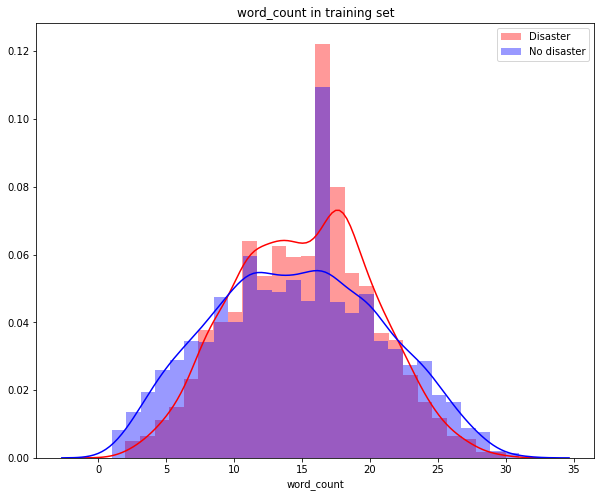

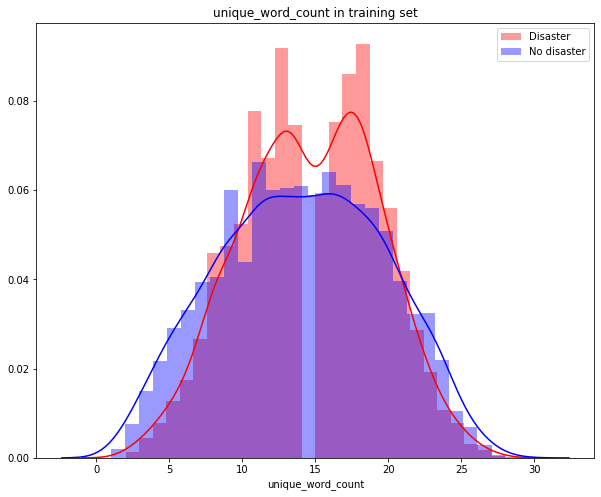

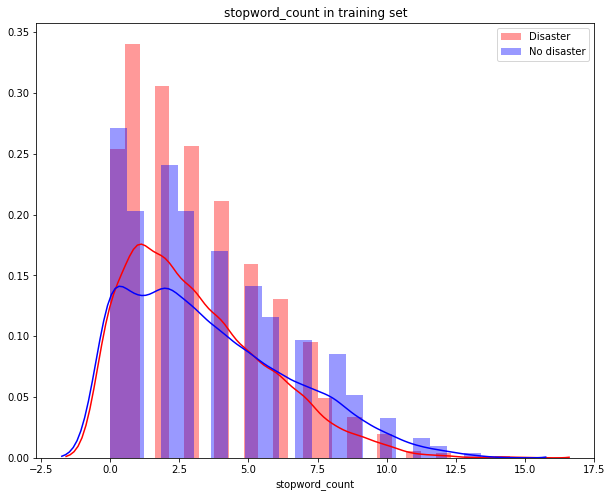

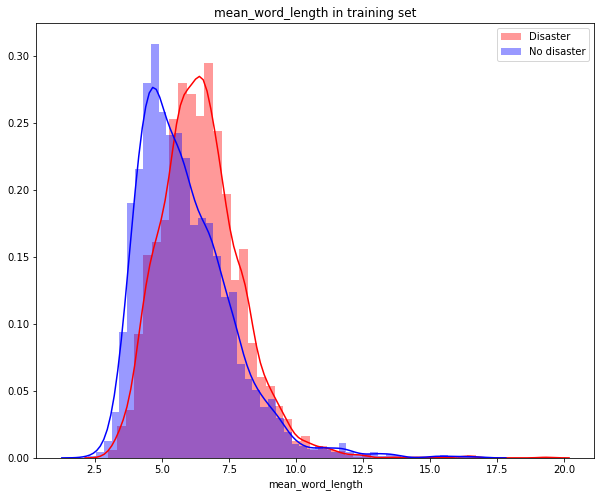

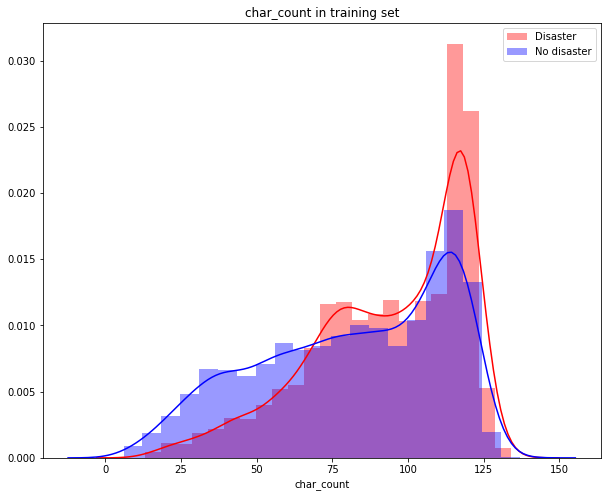

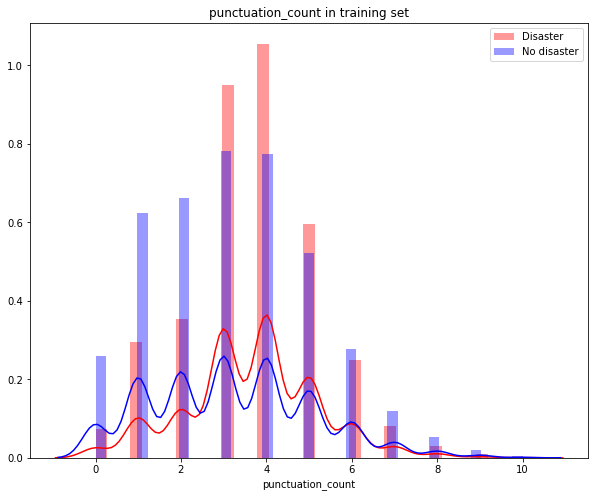

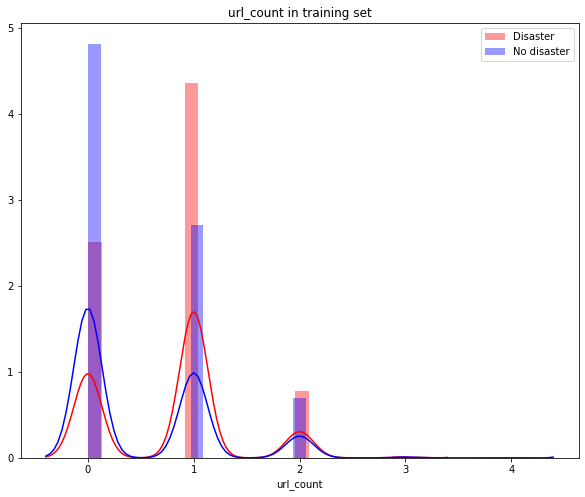

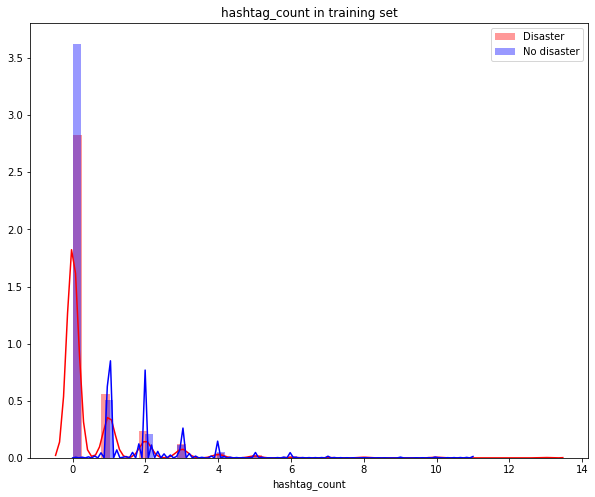

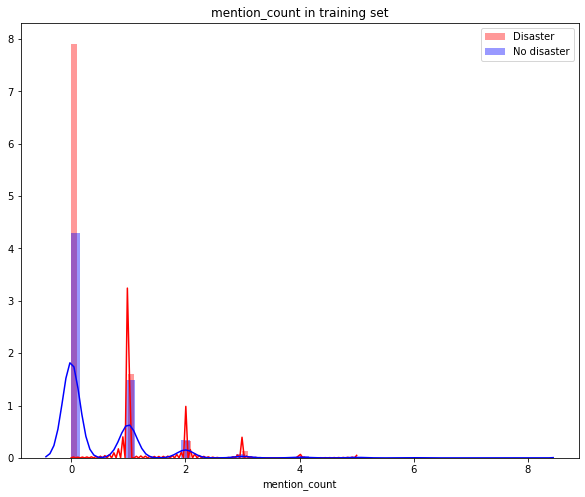

In [ ]:
metafeatures = ["word_count",
                "unique_word_count",
                "stopword_count",
                "mean_word_length",
                "char_count",
                "punctuation_count",
                "url_count",
                "hashtag_count",
                "mention_count"]

for feature in metafeatures:
    plt.figure(figsize=(10,8))
    sns.distplot(training[training["target"] == 1][feature], color = "red", label="Disaster")
    sns.distplot(training[training["target"] == 0][feature], color = "blue", label="No disaster")
    plt.legend()
    plt.title(feature + " in training set")
    plt.show()

Wrapping all the operations to extract the metafeatures above into a single function for later purposes:

In [ ]:
def get_metafeatures(text):
    
    mf_dict = {}
    
    mf_dict["word_count"] = len(text.split())
    mf_dict["unique_word_count"] = len(set(text.split()))
    mf_dict["stopword_count"] = len(set(text.split()).intersection(stopwords))
    mf_dict["mean_word_length"] = np.mean(list(map(len, text.split())))
    mf_dict["char_count"] = sum(list(map(len, text.split())))
    mf_dict["punctuation_count"] = len(set(text).intersection(set(string.punctuation)))
    mf_dict["url_count"] = text.count("/t.co/")
    mf_dict["hashtag_count"] = text.count("#")
    mf_dict["mention_count"] = text.count("@")

    return mf_dict

In [ ]:
training[metafeatures]

,word_count,unique_word_count,stopword_count,mean_word_length,char_count,punctuation_count,url_count,hashtag_count,mention_count
0,13,13,5,4.384615,57,1,0,1,0
1,7,7,0,4.571429,32,1,0,0,0
2,22,20,7,5.090909,112,2,0,0,0
3,8,8,1,7.125000,57,2,0,1,0
4,16,15,5,4.500000,72,1,0,2,0
...,...,...,...,...,...,...,...,...,...
7604,19,19,6,6.210526,118,4,1,1,0
7605,26,25,14,3.423077,89,1,0,0,0
7606,20,18,1,5.100000,102,4,1,0,0
7608,11,11,2,6.636364,73,3,1,0,0


### Data Cleaning

The following steps are aimed at cleaning each tweet text body, so as to have a *normalised* corpus to work with.

Use regex to clean non-standard characters, such as:

        ã, å, ü, \x89Ûª, ...

As an initial (though somewhat drastic) measure just substitute them by an empty substring:

In [ ]:
char_regex = re.compile(r"([^a-zA-Z0-9\./!#£€$%&\'()*+,-./:;<=>?@\[\]\\\^_`{|}~ ]+)")
def char_repl(match):
    return ''

Remove twitter shortened URLs (.../t.co/...), without substituting by any substring, as the metafeature **url_count** may already convey any related information:

In [ ]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return ''

Locate mentions to usernames with the twitter specific syntax (@username) and remove them, as metafeature **mention_count** may account for them:

In [ ]:
user_regex = re.compile(r"@(\w+)")
def user_repl(match):
    return ''

Locate hashtag (#) prepended trending topics, remove the symbol and leave the topic:

In [ ]:
hash_regex = re.compile(r"#(\w+)")
def hash_repl(match):
    return match.group(1)

Locate and remove HMTL tags (<..> ... <..>):

In [ ]:
html_regex = re.compile(r"<.*?>")
def html_repl(match):
    return ''

Remove punctuation, considering metafeature **punctuation_count** may already capture any relevant information:

In [ ]:
def punct_repl(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

Locate emoticons and replace them by suitable descriptors:

In [ ]:
emoticons = \
    [('__EMOT_SMILEY',[':-)', ':)', '(:', '(-:']),\
     ('__EMOT_LAUGH',[':-D', ':D', 'X-D', 'XD', 'xD']),\
     ('__EMOT_LOVE',['<3', ':\*']),\
     ('__EMOT_WINK',[';-)', ';)', ';-D', ';D', '(;', '(-;']),\
     ('__EMOT_FROWN',[':-(', ':(', '):', ')-:']),\
     ('__EMOT_CRY',[':,(', ':\'(', ':"(', ':(('])]
    
def escape_paren(arr):
    return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
    return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

def emoticon_repl(text):
    for (repl, regx) in emoticons_regex:
        text = re.sub(regx, ' ' + repl + ' ', text)
    return text

Repetitions are handled by contracting any sequence of three or more repeated characters to just one:

In [ ]:
rpt_regex = re.compile(r"(.)\1{2,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)

Use an instance of `Spellchecker` to amend common spelling mistakes:

***(Note: The spelling checks involved, though useful, are computationally demanding and time consuming, hence this step is disregarded in subsequent wrappers)***

In [ ]:
def spelling(text):
    
    sc = SpellChecker()
    
    corrected_text = []
    misspelled_words = sc.unknown(text.split())
    
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(sc.correction(word))
        else:
            corrected_text.append(word)
            
    return " ".join(corrected_text)

Use nltk's `PorterStemmer` to stemmize the words constituting the tweets, initially with the constraints:

* words need to be at least 3 characters long
* stopwords are disregarded
* digits are disregarded

In [ ]:
def stemmize(text):
    
    stemmer = nltk.stem.PorterStemmer()
    
    text = [word if (word[0:2] == '__') else word.lower() for word in text.split()\
            if (len(word) >= 3 and word.lower() not in stopwords and word.isalpha())]
    text = [stemmer.stem(w) for w in text] 

    return text

Wrap all the cleaning procedures above into a single function:

In [ ]:
def processAll(text):
    
    text = re.sub(char_regex, char_repl, text)
    text = re.sub(url_regex, url_repl, text)
    text = re.sub(user_regex, user_repl, text)
    text = re.sub(hash_regex, hash_repl, text)
    text = re.sub(html_regex, html_repl, text)
    text = punct_repl(text)
    text = emoticon_repl(text)
    text = text.replace('\'','')
    text = re.sub(rpt_regex, rpt_repl, text)
    
    #text = spelling(text)
    text = stemmize(text)                
    
    return text

Map the wrapper above over the `text` column and store in new column `processed_tweet`:

In [ ]:
training["processed_tweet"] = training["text"].apply(processAll)

In [ ]:
training[["text","processed_tweet"]].head()

,text,processed_tweet
0,Our Deeds are the Reason of this #earthquake M...,"[deed, reason, earthquak, may, allah, forgiv]"
1,Forest fire near La Ronge Sask. Canada,"[forest, fire, near, rong, sask, canada]"
2,All residents asked to 'shelter in place' are ...,"[resid, ask, shelter, place, notifi, offic, ev..."
3,"13,000 people receive #wildfires evacuation or...","[peopl, receiv, wildfir, evacu, order, califor..."
4,Just got sent this photo from Ruby #Alaska as ...,"[got, sent, photo, rubi, alaska, smoke, wildfi..."


Incorporate context infomation by adding extra features in the form of n-grams, initially up to trigrams:

In [ ]:
def get_word_features(words):
    
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

Incorporate the part-of-speech tags for each word, as certain common nouns and adjectives may be related to incidence in disaster-related headlines.

In [ ]:
def get_pos_features(words):
    
    tags = {}
    tagged_words = [ 'has(%s)'% w + '_' + tag for w,tag in nltk.pos_tag(words)]
    
    for tw in tagged_words:
        tags[tw] = 1

    return tags

Join the extraction of features (n-grams and pos-tags) above with the extraction of text metafeatures into a single wrapper:

In [ ]:
def extract_features(text, ft=True, metaft=True, posft=True):
    
    features = {}
    
    words = processAll(text)

    if ft:
        word_features = get_word_features(words)
        features.update(word_features)
    
    if metaft:
        text_metafeatures = get_metafeatures(text)
        features.update(text_metafeatures)
    
    if posft:
        pos_features = get_pos_features(words)
        features.update(pos_features)
    
    return features

Apply the wrapper above to the `text` column and store the processing result into new column `processed_tweet_features`:

In [ ]:
training["processed_tweet_features"] = training["text"].apply(extract_features)

In [ ]:
training[["text","processed_tweet_features"]].head()

,text,processed_tweet_features
0,Our Deeds are the Reason of this #earthquake M...,"{'has(deed)': 1, 'has(reason)': 1, 'has(earthq..."
1,Forest fire near La Ronge Sask. Canada,"{'has(forest)': 1, 'has(fire)': 1, 'has(near)'..."
2,All residents asked to 'shelter in place' are ...,"{'has(resid)': 1, 'has(ask)': 1, 'has(shelter)..."
3,"13,000 people receive #wildfires evacuation or...","{'has(peopl)': 1, 'has(receiv)': 1, 'has(wildf..."
4,Just got sent this photo from Ruby #Alaska as ...,"{'has(got)': 1, 'has(sent)': 1, 'has(photo)': ..."


Inspect the first tweet features:

In [ ]:
training["processed_tweet_features"].loc[0]

{'has(deed)': 1,
 'has(reason)': 1,
 'has(earthquak)': 1,
 'has(may)': 1,
 'has(allah)': 1,
 'has(forgiv)': 1,
 'has(deed,reason)': 1,
 'has(reason,earthquak)': 1,
 'has(earthquak,may)': 1,
 'has(may,allah)': 1,
 'has(allah,forgiv)': 1,
 'has(deed,reason,earthquak)': 1,
 'has(reason,earthquak,may)': 1,
 'has(earthquak,may,allah)': 1,
 'has(may,allah,forgiv)': 1,
 'word_count': 13,
 'unique_word_count': 13,
 'stopword_count': 5,
 'mean_word_length': 4.384615384615385,
 'char_count': 57,
 'punctuation_count': 1,
 'url_count': 0,
 'hashtag_count': 1,
 'mention_count': 0,
 'has(deed)_NN': 1,
 'has(reason)_NN': 1,
 'has(earthquak)_NN': 1,
 'has(may)_MD': 1,
 'has(allah)_VB': 1,
 'has(forgiv)_NN': 1}

### Modelling

Split `training` into a set for proper training and a separate validation set for the cases where `nltk` classifiers are instanstiated instead of `sklearn`, where cross-validation is readily available. *(The option of cross-validation in `nltk` is not investigated due to time constraints).*

In [ ]:
trn_size = 6000

training_trn = [(tweet, target) for tweet, target in training[["text", "target"]].values[:trn_size]]
training_val  = [(tweet, target) for tweet, target in training[["text", "target"]].values[trn_size:]]

Pass the `extract_features` wrapper to `apply_features` for the training and validation sets:

In [ ]:
v_trn = nltk.classify.apply_features(extract_features, training_trn)
v_val = nltk.classify.apply_features(extract_features, training_val)

`v_trn` and `v_val` are `nltk.collections.LazyMap` objects. Each one is represented as a list of tuples, where each tuple comprises:

* a dictionary mapping features to values
* a target label

#### Baseline and variants

In a first instance, just consider that the count of the terms is in itself significant enough to infer the class, i.e. apply `CountVectorizer` to the cleaned stemmed tweets (via `processAll`), and pass the resulting document-term matrix to a classifier. This is not expected to provide a competitive result but it may give a measure of the baseline threshold for the evaluating metric.

To this end, add an extra column with the cleaned tweets as single strings:

In [ ]:
training["processed_text"] = training["processed_tweet"].map(lambda x: " ".join(x))

As optional arguments, expand the count to capture n-grams up to order 3 with tokens that are at least 3 characters long:

In [ ]:
vect = CountVectorizer(ngram_range=(1,3), token_pattern=r"\b\w\w\w+\b")\
                      .fit(training["processed_text"])

Pass the document-term matrix to an unregularised `LogisticRegression` classifier:

In [ ]:
clf_lr = LogisticRegression(solver="lbfgs")

Check the average F1 score after cross-validation:

In [ ]:
scores_lr = cross_val_score(clf_lr,
                            vect.transform(training["processed_text"]),
                            training["target"],
                            cv=10,
                            scoring="f1")

In [ ]:
scores_lr.mean()

0.5320677062916048

For comparison purposes, pass the count matrix to a (multinomial) Naive Bayes classifier:

In [ ]:
clf_nb0 = MultinomialNB()

Check the average F1 score after cross-validation:

In [ ]:
scores_nb0 = cross_val_score(clf_nb0,
                             vect.transform(training["processed_text"]),
                             training["target"],
                             cv=10,
                             scoring="f1")

In [ ]:
scores_nb0.mean()

0.6328497967699407

As expected, the `MultinomialNB` classifer alongside some basic count representation of the tweets already marks a significantly more solid baseline (F1 just below 64%) as compared to the `LogisticRegression` classifier. Let us build up on this before attempting the first submission.

The next step would be to refine the representation of the tokens in the corpus by switching `CountVectorizer` with `TfidfVectorizer`, which is based on term-frequency-inverse-document-frequency values, giving more relevance to rare terms that convey greater meaning. The constraints of n-grams up to order 3 and tokens of at least 3 characters remain in place:

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1,3), token_pattern=r"\b\w\w\w+\b")\
                       .fit(training["processed_text"])

Pass the tfidf document-term matrix to a (multinomial) Naive Bayes classifier:

In [ ]:
clf_nb1 = MultinomialNB()

Check the average F1 score after cross-validation:

In [ ]:
scores_nb1 = cross_val_score(clf_nb1,
                             tfidf.transform(training["processed_text"]),
                             training["target"],
                             cv=10,
                             scoring="f1")

In [ ]:
scores_nb1.mean()

0.5614803361382535

Somewhat surprisingly, `TfidfVectorizer` attains poorer metric results than `CountVectorizer`. There must be a reason underlying this, perhaps related to the words leading this phenomenon. Let us inspect the words associated to the largest frequency values in both cases:

In [ ]:
sorted(list(zip(tfidf.get_feature_names(),
                np.asarray(tfidf.transform(training["processed_text"]).sum(axis=0)).ravel())),
       key=lambda x: x[1],
       reverse=True)[:20]

[('like', 41.5396732592003),
 ('fire', 39.588160100631406),
 ('get', 35.26755847890961),
 ('scream', 30.54592523004894),
 ('bomb', 28.651859734707315),
 ('amp', 28.55233457244267),
 ('via', 26.463191532310496),
 ('dont', 25.664204332549364),
 ('new', 24.89368362044483),
 ('fatal', 24.49980002093268),
 ('one', 24.23516782533189),
 ('peopl', 22.728610323421847),
 ('burn', 22.366027624664365),
 ('news', 21.880188000971156),
 ('crash', 21.757482580681074),
 ('disast', 21.689857134359528),
 ('video', 21.402037660229958),
 ('kill', 21.20583582283886),
 ('love', 21.180414532524672),
 ('flood', 20.54536361361709)]

In [ ]:
sorted(list(zip(vect.get_feature_names(),
                np.asarray(vect.transform(training["processed_text"]).sum(axis=0)).ravel())),
       key=lambda x: x[1],
       reverse=True)[:20]

[('like', 404),
 ('fire', 351),
 ('get', 310),
 ('amp', 296),
 ('new', 225),
 ('bomb', 222),
 ('via', 217),
 ('one', 203),
 ('dont', 201),
 ('peopl', 193),
 ('news', 185),
 ('kill', 176),
 ('video', 169),
 ('burn', 168),
 ('flood', 163),
 ('crash', 161),
 ('emerg', 160),
 ('time', 159),
 ('attack', 152),
 ('bodi', 149)]

Both lists show a sensible collection of tokens (and overlap to a notable extent), perhaps with the only relevant difference being the prevalence of **dont** in the top list of `CountVectorizer`. Still, the difference in F1 score remains unintuitive, but it will not be further looked into for the time being.

#### Naive Bayes (nltk) on all sets of features

Use `nltk` Naive Bayes implemented classifier, gathering all features (meta, n-grams and pos-tags) via the wrapper `extract_features`.

Instantiate a `NaiveBayesClassifier` from within the `nltk` library, and train it with the (proper) training set:

In [ ]:
nb2 = nltk.classify.NaiveBayesClassifier
clf_nb2 = nb2.train(v_trn)

Check the accuracy of the trained Naive Bayes classifier:

In [ ]:
print("Accuracy of the Naive Bayes classifier = ", nltk.classify.accuracy(clf_nb2, v_val))

Accuracy of the Naive Bayes classifier =  0.7697937458416501


Check the metric used in the competition for evaluation (F1 score):

In [ ]:
metrics.f1_score([t[1] for t in v_val], [clf_nb2.classify(d) for d in [t[0] for t in v_val]])

0.7643051771117166

In [ ]:
print('Confusion Matrix')
print()
print(nltk.ConfusionMatrix([t[1] for t in v_val], [clf_nb2.classify(d) for d in [t[0] for t in v_val]]))

Confusion Matrix

  |   0   1 |
--+---------+
0 |<596>218 |
1 | 128<561>|
--+---------+
(row = reference; col = test)



This is already an evaluation metric result closer to the AutoML benchmark (81%), significantly above the metric values resulting from just the word counts.

Generate predictions and prepare results for Kaggle submission:

In [ ]:
v_tst = nltk.classify.apply_features(extract_features,
                                     [tweet for tweet in test["text"].values])

In [ ]:
y_pred = []
for d in v_tst:
    y_pred.append(clf_nb2.classify(d))

In [ ]:
sub_nb2 = pd.DataFrame({"id":test["id"].to_list(),
                        "target":y_pred})

In [ ]:
sub_nb2.to_csv(path + "Submission_nb2.csv", index=False)

Inspect the most representative features of the trained classifier:

In [ ]:
clf_nb2.show_most_informative_features(20)

Most Informative Features
            has(atom)_NN = 1                   1 : 0      =     43.3 : 1.0
          has(atom,bomb) = 1                   1 : 0      =     42.4 : 1.0
              has(spill) = 1                   1 : 0      =     38.7 : 1.0
           has(spill)_NN = 1                   1 : 0      =     36.8 : 1.0
           has(outbreak) = 1                   1 : 0      =     36.8 : 1.0
          has(oil,spill) = 1                   1 : 0      =     33.1 : 1.0
             has(affect) = 1                   1 : 0      =     31.2 : 1.0
               has(atom) = 1                   1 : 0      =     29.4 : 1.0
            has(swallow) = 1                   1 : 0      =     29.4 : 1.0
            has(raze)_NN = 1                   1 : 0      =     28.4 : 1.0
            has(reunion) = 1                   1 : 0      =     26.6 : 1.0
         has(reunion)_NN = 1                   1 : 0      =     26.6 : 1.0
         has(airport)_NN = 1                   1 : 0      =     25.6 : 1.0

Upon initial inspection, none of the features considered informative are counterintuitive.

#### Maximum Entropy (nltk) on all sets of features

Use `nltk` Maxent implemented classifier, gathering all features (meta, n-grams and pos-tags) via the wrapper `extract_features`.

Instantiate a `MaxentClassifier` from within the `nltk` library, and train it with the (proper) training set:

In [ ]:
me = nltk.classify.MaxentClassifier
clf_me = me.train(v_trn, algorithm='GIS', max_iter=15)

  ==> Training (15 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.417
             2          -0.69303        0.940
             3          -0.69292        0.940
             4          -0.69280        0.940
             5          -0.69269        0.940
             6          -0.69257        0.940
             7          -0.69246        0.940
             8          -0.69234        0.940
             9          -0.69223        0.940
            10          -0.69211        0.940
            11          -0.69200        0.940
            12          -0.69188        0.940
            13          -0.69177        0.940
            14          -0.69165        0.940
         Final          -0.69154        0.940


Check the F1 score on the validation set:

In [ ]:
metrics.f1_score([t[1] for t in v_val], [clf_me.classify(d) for d in [t[0] for t in v_val]])

0.6984969053934572

The `MaxEntClassifier` is less constrained than Naive Bayes in the assumptions it makes, but it is computationally more demanding (hence the cutoff `max_iter` above, which leaves as an open issue to which extent the score would improve if such cutoff were removed). The resulting evaluation score suggests that this model would not necessarily generalise better than the previous Naive Bayes classifier, but strictly speaking this would need thorough checking.

#### Naive Bayes (sklearn) on all sets of features

Instantiate classifiers from the `sklearn` library. To this end, the dataframe of features needs some processing. Ultimately, `training_skl` gathers all the features from the dictionaries in the column `processed_tweet_features` of dataframe `training`:

In [ ]:
training_whole = [(tweet, target) for tweet, target in training[["text", "target"]].values]

In [ ]:
v_whole = nltk.classify.apply_features(extract_features, training_whole)

In [ ]:
training_skl = pd.DataFrame([t[0] for t in v_whole])

In [ ]:
training_skl.set_index(training["id"], inplace=True)

In [ ]:
training_skl.shape

(7503, 107226)

In [ ]:
training_metafeatures = training_skl[metafeatures].copy()

In [ ]:
training_metafeatures.shape

(7503, 9)

In [ ]:
training_skl.drop(metafeatures, axis=1, inplace=True)

Scale the values in the columns gathered in `metafeatures`:

In [ ]:
ss = StandardScaler()
mms = MinMaxScaler()

In [ ]:
training_metafeatures = pd.DataFrame(mms.fit_transform(ss.fit_transform(training_metafeatures)),
                                     columns = metafeatures,
                                     index = training_metafeatures.index)

In [ ]:
training_skl.fillna(0, inplace=True)

In [ ]:
training_skl = pd.concat([training_skl, training_metafeatures], axis=1)

In [ ]:
training_skl.shape

(7503, 107226)

Once `training_skl` is assembled, instantiate classifiers for cross-validation:

In [ ]:
mnb = MultinomialNB()

In [ ]:
scores_mnb = cross_val_score(mnb, training_skl, training["target"], cv=5, scoring="f1")

In [ ]:
scores_mnb.mean()

0.6612318544751581

The resulting F1 score is considerably lower than the one resulting from the NB classifier implemented in `nltk`, though this could be partially expected since in `nltk` no k-fold cross-validation was performed, just one single split.

Just to check the significance of some feature groups separately, train another `MultinomialNB` on a set of features excluding `metafeatures`:

In [ ]:
mnb2 = MultinomialNB()

In [ ]:
scores_mnb2 = cross_val_score(mnb2, training_skl.drop(metafeatures,axis=1), training["target"], cv=5, scoring="f1")

In [ ]:
scores_mnb2.mean()

0.6637095360835035

The achieved F1 score is roughly the same as the previous one, which suggests that the significance of `metafeatures` is marginal at best, if not detrimental. Train yet another NB classifier with just this subset:

In [ ]:
mnb3 = MultinomialNB()

In [ ]:
scores_mnb3 = cross_val_score(mnb3, training_skl[metafeatures], training["target"], cv=5, scoring="f1")

In [ ]:
scores_mnb3.mean()

0.006224833159520657

For some reason, `metafeatures` by themselves perform extremely poorly. Hence, even though it was intuitive to think of them as useful features, it seems they should be disregarded. Perhaps it could be worth investigating if a certain subset within `metafeatures` is still of help, but this is left for later stages.

#### SVC

To check the effect of changing the classifier, train a regularised linear support vector classifier with all features except `metafeatures`:

In [ ]:
lsvc = SGDClassifier()

In [ ]:
scores_lsvc = cross_val_score(lsvc, training_skl.drop(metafeatures,axis=1), training["target"], cv=5, scoring="f1")

In [ ]:
scores_lsvc.mean()

0.5784140138060451

#### Naive Bayes (sklearn) CountVectorizer + Features

This classifier achieves an even lower average F1 score than the baseline `nltk` Naive Bayes with word counts.

Recalling that the `CountVectorizer` was a solid baseline, mix the resulting term-document matrix with the subset of features used above, and train a Naives Bayes classifier with it:

In [ ]:
training_skl2 = pd.concat([training_skl.drop(metafeatures,axis=1),
                           pd.DataFrame(vect.transform(training["processed_text"]).todense(), index=training["id"])],
                           axis=1)

In [ ]:
mnb4 = MultinomialNB()

In [ ]:
scores_mnb4 = cross_val_score(mnb4, training_skl2, training["target"], cv=5, scoring="f1")

In [ ]:
scores_mnb4.mean()

0.6593569970341029

Even though the combination of counts with features (overlappings of n-grams aside) seems to have a positive effect (F1 score improves the baseline), this effect is limited as the score is notably below the reference Naive Bayes classifier.

### Conclusions

Following data exploration and amendment of some `target` inconsistencies in repeated tweets, a number of regex-led cleaning steps are defined in text pre-processing, alongside extraction of some (meta)features arising directly from the corpus. All these steps are conveniently gathered in wrapper functions.

Aside from this (count) metafeatures, some additional features related to context (n-grams up to order 3) and part-of-speech tags are also incorporated. Stopwords, tokens shorter than 3 characters and digits are disregarded altogether. Although `word_tokenize` is not applied directly, tokenization occurs either inside `CountVectorizer` or in the `processAll` wrapper. Parsing has not been considered here, mainly due to time constraints and computational expense (experience with `nltk.ChartParser` substantiates this) though it could have been very useful otherwise. 

It is considered that something is essentially incorrect in either the choice of some features or their implementation, as some results have shown to be counterintuitive. `TfidfVectorizer` has led to poorer metrics than `CountVectorizer`, and the metafeatures are seemingly irrelevant (if not detrimental) as compared to standalone term-document matrix or (n-gram and pos-tag) features.

An instance of Naive Bayes as implemented in `nltk` and trained over all features has led to the best average validated F1 score and hence constitutes the model submitted to the Kaggle competition. Variations in the training features or the classifier have not succeeded in improving this reference score (~ 77.5% in the public leaderboard at the time of submission). This reinforces the notion that there is an unexplained underlying reason for the limited performance, since relatively standard classifiers should  allow for reaching the AutoML benchmark score (81%). Perhaps the regex-based functions should be revisited, and also a more efficient spelling checker could be implemented (as the one initially considered here turned out to be too costly).

Deep learning or Transformers are enticing alternatives that were ultimately dropped, not just because of time constraints but also because it is deemed that finding an appropriate set of features is more important than the muscle of the classifier. Since the former point was not fully achieved here, the use of a deep learning classifier would have not amounted to much, even if the F1 score increased.